# Physical scene understanding lab

This lab introduces concepts and tools for inferring the properties of physical scenes. 



In [2]:
# Activate package
using Pkg;
# set to your project env
Pkg.activate("/home/psyc261_meb266/Algorithms-of-the-Mind/jenv");

  Activating project at `~/Algorithms-of-the-Mind/jenv`


## The task: inference by reversing physical simulation

In order to effectively interact with the world around us, our minds must continually infer the latent properties determining physical events. Popularized by Battalgia 2013, the "physics engine in the mind" refers to a general schema where the mind uses a physical simulator to explore how well different hypothesis over physical properties can explained dynamic scenes. Here, we implement a model that uses the [pybullet](https://pybullet.org/wordpress/) physics engine to simulate the trajectory of a ball given different hypotheses about it's [coefficient of restitution](https://en.wikipedia.org/wiki/Coefficient_of_restitution) and mass. We will also explore inference procedures, such as [particle filters](https://en.wikipedia.org/wiki/Particle_filter) that leverage the sequential nature of the underlying world model to efficiently update physical hypotheses. 

## Setup

Since this lab uses some extra dependencies, please make sure to follow these instructions carefully. 

### First time installations

> NOTE: You should only need to run this section once! After the dependencies are installed, you should not evaulate this section again.

We will need to install [pybullet](https://pybullet.org/wordpress/), the real time physics engine that we will be using under the hood.The `PyCall` package should take care of this for you in `pyimport`. 



In [5]:
using PyCall
pb = pyimport("pybullet");

With this, we can install several julia packages. The first two provide functionality for inference over physical scenes. 

> Copy this to a new cell and execute
```julia
Pkg.add(url="https://github.com/CNCLgithub/PhySMC.git");
Pkg.add(url="https://github.com/CNCLgithub/PhyBullet.git");
Pkg.add("Accessors");
Pkg.add("Distributions");
```

### Loading dependencies


In [3]:
using Gen;
using PhySMC;
using PhyBullet;
using PyCall; # helps with python commands
using Accessors; #helps with manipulating obj data

pybullet build time: May  2 2023 06:00:32


## Physical Generative Model

The generative model (`model`) samples a hypothesis over objects in the scene and uses the bullet physics engine to produce a sequence of predictions about the object state across time.

![](media/phys_gm.png)

The generative model is split up into several small generative functions: 

1) `prior` samples new latents (mass and restitution) defining the first world state
2) `kernel` simulates `t` steps into the future, generating world states for each step
3) `observe` generates noisy observations over object positions (in $\mathcal{R}^3$) for a given state

In [4]:
# helper function
function update_latents(ls::RigidBodyLatents, mass::Float64, res::Float64)
    RigidBodyLatents(setproperties(ls.data;
                           mass = mass,
                           restitution = res))
end

@gen function prior(ls::RigidBodyLatents)
    mass = @trace(gamma(1.2, 10.), :mass)
    res = @trace(uniform(0, 1), :restitution)
    new_latents = update_latents(ls, mass, res)
    return new_latents
end

@gen function observe(k::RigidBodyState)
    pos = k.position # XYZ position
    # add noise to position
    obs = @trace(broadcasted_normal(pos, 0.1), :position)
    return obs
end

@gen function kernel(t::Int, prev_state::BulletState, sim::BulletSim)
    # use of PhySMC.step
    next_state::BulletState = PhySMC.step(sim, prev_state)
    # elem state could be a different type
    # but here we only have one `RigidBody` element
    # so  `next_state.kinematics = [RigidBodyState]`
    obs = @trace(Gen.Map(observe)(next_state.kinematics), :observe)
    return next_state
end

@gen function model(t::Int, sim::BulletSim, template::BulletState)
    # sample new mass and restitution for objects
    latents = @trace(Gen.Map(prior)(template.latents), :prior)
    init_state = setproperties(template; latents = latents)
    # simulate `t` timesteps
    states = @trace(Gen.Unfold(kernel)(t, init_state, sim), :kernel)
    return states
end;

## Defining a physical scene

Importantly, `model` (thanks to  `PhySMC` and `PhyBullet`) just needs an initialize scene to start producing simulations.
Here, let's use `PhySMC` and `PhyBullet` to initialize a simple scene: a table with a ball directly above its center. 

In [5]:
function simple_scene(mass::Float64=1.0,
                      restitution::Float64=0.9)
    # `pb` is the `pybullet` python packaged and is exported by `PhyBullet`
    # initialize a physics server
    client = @pycall pb.connect(pb.DIRECT)::Int64
    pb.setGravity(0,0,-10; physicsClientId = client)

    # add a table
    dims = [1.0, 1.0, 0.1] # in meters
    col_id = pb.createCollisionShape(pb.GEOM_BOX,
                                     halfExtents = dims,
                                     physicsClientId = client)
    obj_id = pb.createMultiBody(baseCollisionShapeIndex = col_id,
                                basePosition = [0., 0., -0.1],
                                physicsClientId = client)
    pb.changeDynamics(obj_id,
                      -1;
                      mass = 0., # 0 mass are stationary
                      restitution = 0.9, # some is necessary
                      physicsClientId=client)


    # add a ball
    bcol_id = pb.createCollisionShape(pb.GEOM_SPHERE,
                                      radius = 0.1,
                                      physicsClientId = client)
    bobj_id = pb.createMultiBody(baseCollisionShapeIndex = bcol_id,
                                 basePosition = [0., 0., 1.0],
                                 physicsClientId = client)
    pb.changeDynamics(bobj_id,
                      -1;
                      mass = mass,
                      restitution = restitution,
                      physicsClientId=client)

    (client, bobj_id)
end

# start with a ball above a table
client, ball_id = simple_scene()
# configure simulator with the provided
# client id
sim = BulletSim(;client=client)
# This is the object of interest in the scene
# (the table is static)
ball = RigidBody(ball_id)
# Retrieve the default latents for the ball
# as well as its initial positions
# Note: alternative latents will be suggested by the `prior`
init_state = BulletState(sim, [ball])
# arguments for `model`
gargs = (60, # number of steps (total duration 1s)
         sim,
         init_state);

Here, you will see several new expressions:

- `BulletSim`
- `BulletState`
- `RigidBody`

We can inspect their docstrings for more info.

In [15]:
@doc BulletSim

Parameters for using the Bullet physics engine

```julia
struct BulletSim <: PhySim
```

---

  * `client::Int64`: Client id for pybullet
  * `step_dur::Float64`: Amount of time between `forward_steps` (default=16.7ms) Default: 1 / 60
  * `pb_timestep::Float64`: Timestep duration of bullet engine (default: 4.2ms) Default: 1 / 240


In [13]:
@doc BulletState

State for `BulletSim`

```julia
struct BulletState <: PhyState{BulletSim}
```

---

  * `elements::AbstractVector{BulletElement}`
  * `latents::AbstractVector{BulletElemLatents}`
  * `kinematics::AbstractVector{BulletElemState}`


In [14]:
@doc RigidBody

A rigid body in `BulletSim`

```julia
struct RigidBody <: BulletElement
```

Consists of a single base collision object.

---

  * `object_id::Int64`: The `bodyUniqueId` of the base object


With the simulator configured to start with the template scene, we can go ahead and run the generative model.

>Note how the different physical and kinematic properties of the objects are referenced in a generic way in `model`. This allows us to possible start with more complex scenes than the one we use in this example. 

In [6]:
# execute `model`
trace, _ = generate(model, gargs);
get_choices(trace);

That was anti-climactic. Let's also create a helper function to visualize the height of the ball as a function of time

> `pybullet` comes with a debug gui to visualize simulations but this would require a complicated setup for jupyter notebooks.

In [7]:
using Plots;

@userplot SimPlot
@recipe function f(cp::SimPlot)
    z, t = cp.args
    cs = size(z, 1)
    k = 10
    inds = (max(1, t-k):t)
    n = length(inds)
    linewidth --> range(0, 10, length = n)
    seriesalpha --> range(0, 1, length = n)
    xguide --> "time"
    yguide --> "height of ball (z)"
    ylims --> (0, 1.0)
    xlims --> (1, 60)
    label --> false
    inds, z[inds, :]
end

function get_zs(trace::Gen.Trace)
    t, _... = get_args(trace)
    states = get_retval(trace)
    zs = Vector{Float64}(undef, t)
    for i = 1:t
        zs[i] = states[i].kinematics[1].position[3]
    end
    return zs
end

function animate_trace(trace::Gen.Trace; label = "trace")
    t = first(get_args(trace))
    zs = reshape(get_zs(trace), (t, 1))
    anim = @animate for i = 2:t
        simplot(zs, i, label = label)
    end
end;

┌ Info: Saved animation to 
└   fn = "/home/psyc261_meb266/Algorithms-of-the-Mind/labs/galileo/tmp.gif"


Plots.AnimatedGif("/home/psyc261_meb266/Algorithms-of-the-Mind/labs/galileo/tmp.gif")
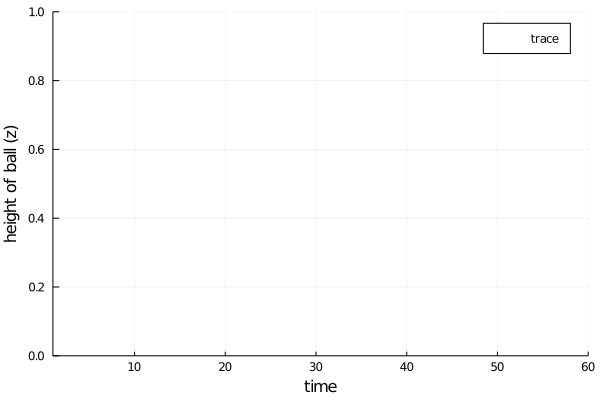

In [8]:
anim = animate_trace(trace)
gif(anim, fps = 24)

By repeatedly running `Gen.generate` on `model`, we draw a variety of samples from the prior and thus traces. Here, we visualize how traces that sample a range of physical properties for the ball lead to different timecourses. 

In [9]:
traces = [first(generate(model, gargs)) for _ = 1:5];

In [10]:
function animate_traces(traces::Vector{<:Gen.Trace})
    n = length(traces)
    zzs = reduce(hcat, map(get_zs, traces))
    t = size(zzs, 1)
    anim = @animate for i = 2:t
        simplot(zzs, i)
    end
end

animate_traces (generic function with 1 method)

┌ Info: Saved animation to 
└   fn = "/home/psyc261_meb266/Algorithms-of-the-Mind/labs/galileo/tmp.gif"


Plots.AnimatedGif("/home/psyc261_meb266/Algorithms-of-the-Mind/labs/galileo/tmp.gif")
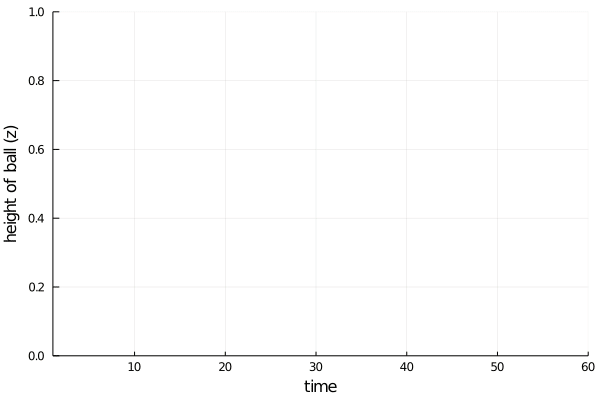

In [11]:
gif(animate_traces(traces), fps = 24)

Note how restitution, and not mass, has any effect on the resulting trajectory. 

## Inference over dynamic scenes

Now that we have implemented a forward model over this simple scene, we can use to perform inferences given a set of observed positions




┌ Info: Saved animation to 
└   fn = "/home/psyc261_meb266/Algorithms-of-the-Mind/labs/galileo/tmp.gif"


Plots.AnimatedGif("/home/psyc261_meb266/Algorithms-of-the-Mind/labs/galileo/tmp.gif")
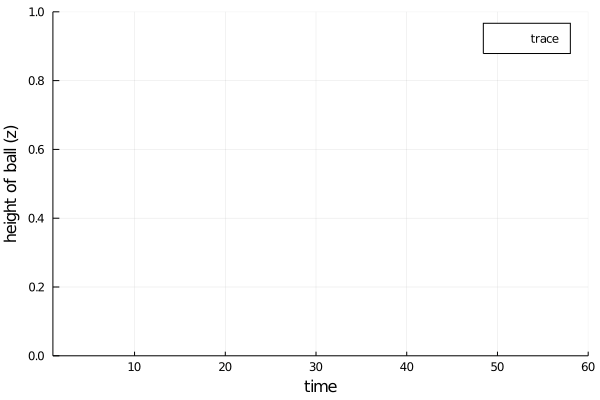

In [12]:
# First, let's generate a scene with a specific mass and restitution 
# (Note: this is "god-like" knowledge
gt_latents = choicemap(
    (:prior => 1 => :restitution, 0.8), 
    (:prior => 1 => :mass, 1.0))
gt = first(generate(model, gargs, gt_latents));
gt_choices = get_choices(gt)

t = gargs[1]

# one set of observations per time step
# (these do not contain gt latents)
observations = Vector{Gen.ChoiceMap}(undef, t)
for i = 1:t
    cm = choicemap()
    addr = :kernel => i => :observe
    set_submap!(cm, addr, get_submap(gt_choices, addr))
    observations[i] = cm
end

gif(animate_trace(gt), fps = 24)

Here, we define the inference procedure: a particle filter 

In [13]:
# First, we define a distribution that will be helpful in the proposal function
using Distributions
struct TruncNorm <: Gen.Distribution{Float64} end
const trunc_norm = TruncNorm()
function Gen.random(::TruncNorm, mu::U, noise::T, low::T, high::T) where {U<:Real,T<:Real}
    d = Distributions.Truncated(Distributions.Normal(mu, noise),
                                low, high)
    return Distributions.rand(d)
end;
function Gen.logpdf(::TruncNorm, x::Float64, mu::U, noise::T, low::T, high::T) where {U<:Real,T<:Real}
    d = Distributions.Truncated(Distributions.Normal(mu, noise),
                                low, high)
    return Distributions.logpdf(d, x)
end;


# this proposal function implements a truncated random walk for mass and restitution
@gen function proposal(tr::Gen.Trace)
    # HINT: https://www.gen.dev/tutorials/iterative-inference/tutorial#mcmc-2
    #
    # get previous values from `tr`
    choices = get_choices(tr)
    prev_mass = choices[:prior => 1 => :mass]
    prev_res  = choices[:prior => 1 => :restitution]
    
    # sample new values conditioned on the old ones
    # (Note: values are truncated to avoid issues with simulation)
    mass = {:prior => 1 => :mass} ~ trunc_norm(prev_mass, .1, 0., Inf)
    restitution = {:prior => 1 => :restitution} ~ trunc_norm(prev_res, .1, 0., 1.)
    
    # the return of this function is not
    # neccessary but could be useful
    # for debugging.
    return (mass, restitution)
end

"""
    inference_procedure

Performs particle filter inference with rejuvenation.
"""
function inference_procedure(gm_args::Tuple,
                             obs::Vector{Gen.ChoiceMap},
                             particles::Int = 20)
    get_args(t) = (t, gm_args[2:3]...)

    # initialize particle filter
    state = Gen.initialize_particle_filter(model, get_args(0), EmptyChoiceMap(), particles)
    argdiffs = (UnknownChange(), NoChange(), NoChange()) # only the first argument will change
    # Then increment through each observation step
    for (t, o) = enumerate(obs)
        # apply a rejuvenation move to each particle
        step_time = @elapsed begin
            for i=1:particles
                state.traces[i], _  = mh(state.traces[i], proposal, ())
            end
        
            Gen.maybe_resample!(state, ess_threshold=particles/2) 
            Gen.particle_filter_step!(state, get_args(t), argdiffs, o)
        end
    end

    return state.traces
    # return the "unweighted" set of traces after t steps
    # return Gen.sample_unweighted_traces(state, particles)
end;

We can now apply this inference procedure to infer the latents in our model that will best explain the set of observed positions. 

In [14]:
result = inference_procedure(gargs, observations); #should take a few seconds

Visualizing the predictions of these traces, we can see that the inference procedure can generally re-create the ground truth trajectory. 

┌ Info: Saved animation to 
└   fn = "/home/psyc261_meb266/Algorithms-of-the-Mind/labs/galileo/tmp.gif"


Plots.AnimatedGif("/home/psyc261_meb266/Algorithms-of-the-Mind/labs/galileo/tmp.gif")
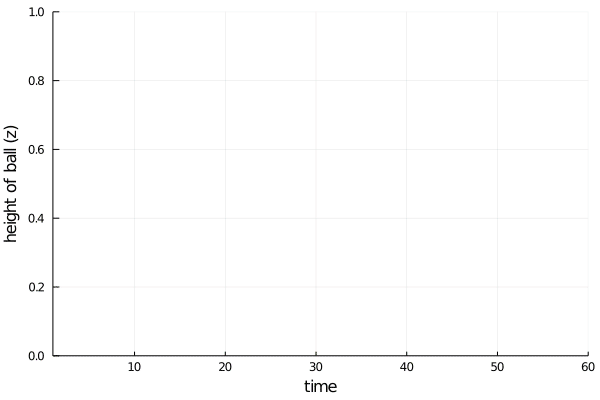

In [15]:
gif(animate_traces(result), fps = 24)

By plotting the distribution of inferred latents, we see that indeed restitution converges to the ground truth, while mass varies arbitrarily.

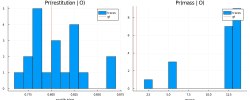

In [23]:
function get_latents(traces::Vector{<:Gen.Trace})
    n = length(traces)
    mass = Vector{Float64}(undef, n)
    restitution = Vector{Float64}(undef, n)
    for i = 1:n
        mass[i] = traces[i][:prior => 1 => :mass]
        restitution[i] = traces[i][:prior => 1 => :restitution]
    end
    (mass, restitution)
end

function plot_latents(traces::Vector{<:Gen.Trace})
    mass, restitution = get_latents(traces)
    res_plt = histogram(restitution, title="Pr(restitution | O)", 
        xlabel="restitution", bins = 10, label = "traces")
    vline!(res_plt, [0.8], label = "gt") 
    mass_plt = histogram(mass, title="Pr(mass | O)", xlabel="mass", bins=10,
        label = "traces")
    vline!(mass_plt, [1.0], label = "gt") 
    return plot(res_plt, mass_plt,size=(1000,400))
end

plot_latents(result)